# Introduction to Qiskit

Qiskit [kiss-kit] is an open-source SDK for working with quantum computing.

Qiskit has different components:

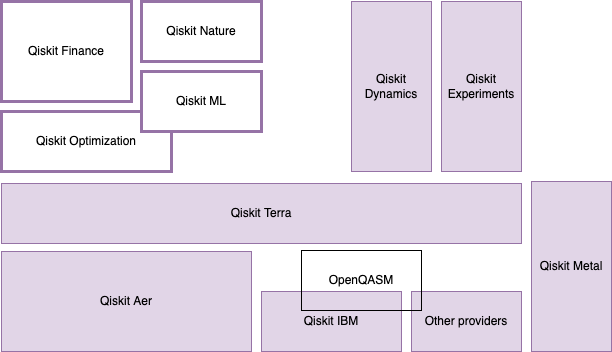

 * **Qiskit Terra**, the core module in which all of the others are based.
 * **Qiskit Aer**, the module which contains all simulators.
 * **Qiskit Application packages**, these are 4 modules, **Machine Learning**, **Nature**, **Finance**, and **Optimization**, they target specific domains and plug into the tools used by experts.
 * **Qiskit Dynamics**, provides access to different numerical methods for solving differential equations
 * **Qiskit IBM** Quantum Provider, the module that enables us to access real quantum hardware in the cloud.
 * **Qiskit Experiments** (aka Ignis), the module that contains all the required tools to implement error mitigation techniques.   
 * **Qiskit Metal**, a framework for engineering and designing superconducting quantum devices.


### installation

For this talk, we need Qiskit terra, aer, and the provider

```
pip install qiskit-terra qiskit-aer qiskit-ibmq-provider
```

In [ ]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)

In [ ]:
circuit.draw()

In [ ]:
circuit.draw('latex_source')

In [ ]:
# Change the default drawer

from qiskit import user_config
user_config.set_config('circuit_drawer', 'mpl')

In [ ]:
from qiskit import Aer

sim = Aer.get_backend('unitary_simulator')
result = sim.run(circuit).result()
matrix = result.get_unitary()
matrix

In [ ]:
from qiskit.visualization import array_to_latex
array_to_latex(result.get_unitary())

In [ ]:
sim = Aer.get_backend('statevector_simulator')
result = sim.run(circuit).result()
psi  = result.get_statevector(circuit)
array_to_latex(psi)

In [ ]:
from qiskit.visualization import plot_state_city
plot_state_city(psi)

In [ ]:
from qiskit.visualization import plot_state_paulivec

plot_state_paulivec(psi)

In [ ]:
from qiskit.visualization import plot_state_qsphere

plot_state_qsphere(psi)

In [ ]:
circuit.draw()

In [ ]:
# Measure the circuit

circuit.measure_all()  # <- this is important!

In [ ]:
circuit.draw()

In [ ]:
sim = Aer.get_backend('aer_simulator')
result = sim.run(circuit).result()
counts = result.get_counts()
counts

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

In [ ]:
circuit1 = QuantumCircuit(2, 3)
circuit1.h(0)
circuit1.cx(0,1)
circuit1.measure(0, 0)
circuit1.measure(1, 1)
circuit1.measure(1, 2)
circuit1.draw(cregbundle=False)

In [ ]:
result = sim.run(circuit1).result()
counts = result.get_counts()
counts

## Let's run it on real hardware!

Get your access token

Log in https://quantum-computing.ibm.com/

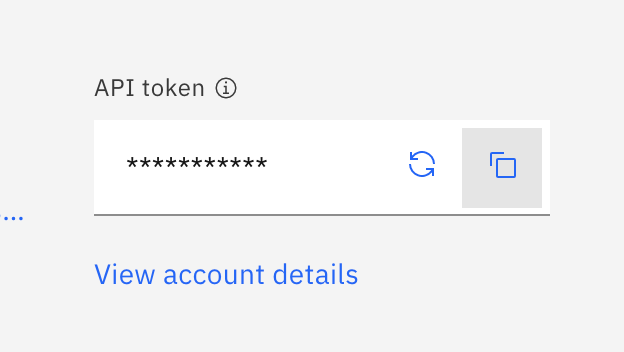

In [ ]:
from qiskit import IBMQ

# IBMQ.save_account(<paste API token here>)
provider = IBMQ.load_account()
[(b.name(), b.configuration().n_qubits) for b in provider.backends()]

In [ ]:
provider = IBMQ.get_provider("ibm-q-internal")                  
[(b.name(), b.configuration().n_qubits) for b in provider.backends()]

In [ ]:
import qiskit.tools.jupyter

%qiskit_backend_overview

In [ ]:
from qiskit.providers.ibmq import least_busy

backend = least_busy(provider.backends(
                simulator=False,
                filters=lambda b: b.configuration().n_qubits >= 2))
backend

In [ ]:
# a remainder
result = sim.run(circuit).result()
counts = result.get_counts()
counts

In [ ]:
job = backend.run(circuit)

In [ ]:
job.status()

In [ ]:
job.result()

In [ ]:
circuit.draw('mpl')

### We need to transpile it

In [ ]:
from qiskit import transpile

transpiled_circuit = transpile(circuit, backend)
transpiled_circuit.draw('mpl')

In [ ]:
job = backend.run(transpiled_circuit)

In [ ]:
job.status()

In [ ]:
result = job.result()
counts = result.get_counts()
counts

In [ ]:
plot_histogram(counts)

In [ ]:
qc = QuantumCircuit(1, 1)
for _ in range(100):
    qc.h(0)
qc.h(0)
qc.measure(0, 0)
qc.draw()

In [ ]:
job = backend.run(transpile(qc, backend, optimization_level=0))

In [ ]:
result = job.result()
counts = result.get_counts()
counts

## Transpiler

In [ ]:
from qiskit.visualization import plot_circuit_layout, plot_gate_map

display(transpiled_circuit.draw(idle_wires=False))
display(plot_gate_map(backend))
plot_circuit_layout(transpiled_circuit, backend)

In [ ]:
# a slightly more interesting example:
circuit = QuantumCircuit(3)
circuit.h([0,1,2])
circuit.ccx(0, 1, 2)
circuit.h([0,1,2])
circuit.ccx(2, 0, 1)
circuit.h([0,1,2])
circuit.measure_all()

display(circuit.draw())
transpiled = transpile(circuit, backend)
transpiled.draw(idle_wires=False, fold=-1)

In [ ]:
# initial layout

transpiled = transpile(circuit, backend, initial_layout=[0,2,3])
display(plot_circuit_layout(transpiled, backend))
plot_gate_map(backend)

In [ ]:
transpiled.draw(idle_wires=False, fold=-1)

In [ ]:
level0 = transpile(circuit, backend, optimization_level=0)
level1 = transpile(circuit, backend, optimization_level=1)
level2 = transpile(circuit, backend, optimization_level=2)
level3 = transpile(circuit, backend, optimization_level=3)

In [ ]:
for level in [level0, level1, level2, level3]:
    print(level.count_ops()['cx'], level.depth())

In [ ]:
# transpiling is a stochastic process 

transpiled = transpile(circuit, backend, optimization_level=2, seed_transpiler=0)
transpiled.depth()

In [ ]:
transpiled = transpile(circuit, backend, optimization_level=2, seed_transpiler=1)
transpiled.depth()

In [ ]:
# Playing with other transpiler options
# (without a backend)

In [ ]:
transpiled = transpile(circuit)
transpiled.draw(fold=-1)

In [ ]:
# target basis gates
transpiled = transpile(circuit, basis_gates=['x', 'cx', 'h', 'p'])
transpiled.draw(fold=-1)

In [ ]:
# set a coupling map

from qiskit.transpiler import CouplingMap

transpiled = transpile(circuit,
                       coupling_map=CouplingMap([(0,1),(1,2)]))
transpiled.draw(fold=-1)

In [ ]:
# set an initial_layout in the coupling map

transpiled = transpile(circuit,
                       coupling_map=CouplingMap([(0,1),(1,2)]),
                       initial_layout=[1, 0, 2])
transpiled.draw(fold=-1)

In [ ]:
# set an initial_layout in the coupling map with basis gates

transpiled = transpile(circuit,
                       coupling_map=CouplingMap([(0,1),(1,2)]),
                       initial_layout=[1, 0, 2],
                       basis_gates=['x', 'cx', 'h', 'p']
                      )
transpiled.draw(fold=-1)

In [ ]:
# how to reduce the approximation dial

transpiled = transpile(circuit,
                       coupling_map=CouplingMap([(0,1),(1,2)]),
                       initial_layout=[1, 0, 2],
                       basis_gates=['x', 'cx', 'h', 'p'],
                       approximation_degree=0.99,
                       optimization_level=3
                      )
transpiled.draw(fold=-1)

In [ ]:
transpiled = transpile(circuit,
                       coupling_map=CouplingMap([(0,1),(1,2)]),
                       initial_layout=[1, 0, 2],
                       basis_gates=['x', 'cx', 'h', 'p'],
                       approximation_degree=0.01,
                       optimization_level=3
                      )
transpiled.draw(fold=-1)

# The pass manager

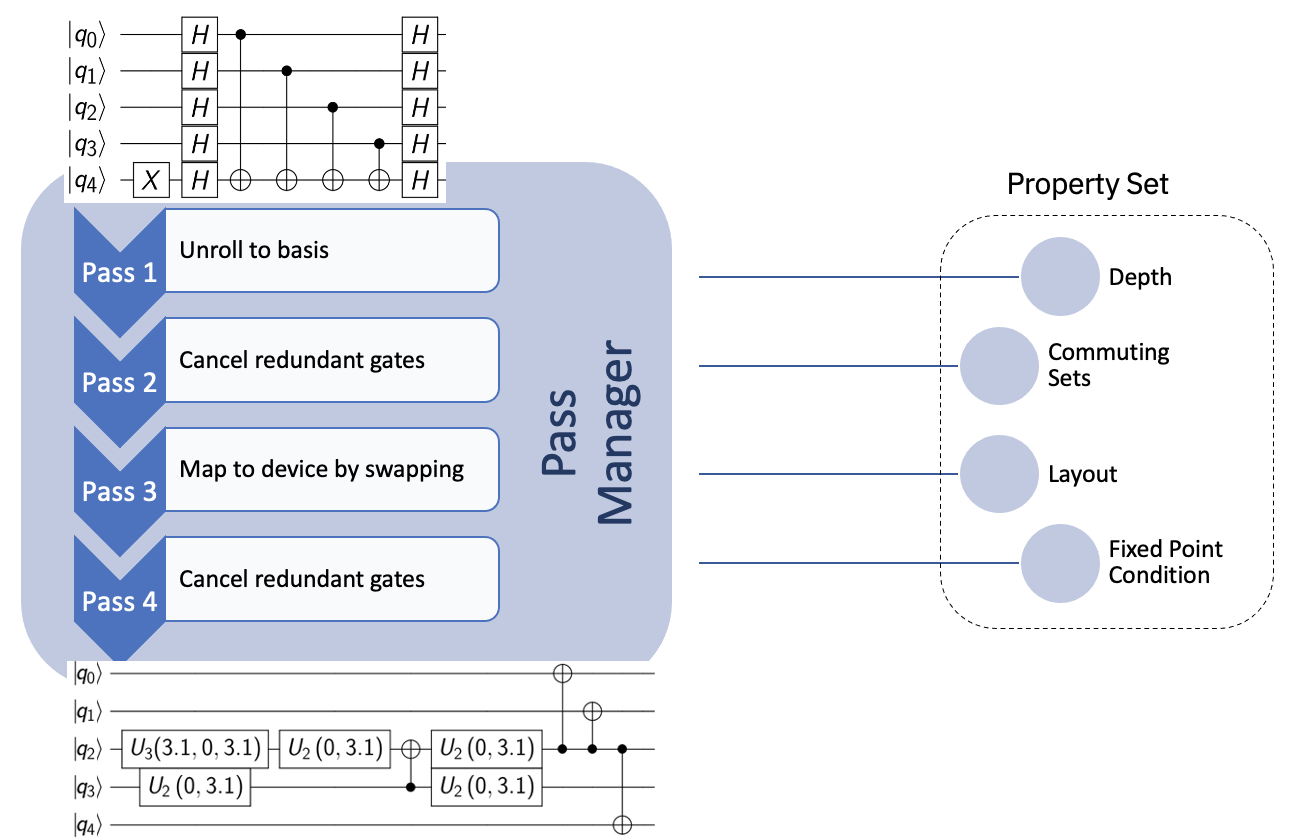

In [ ]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import CheckMap, CheckCXDirection

coupling_map = CouplingMap([[0,1], [1,2]])
pm = PassManager()
pm.append(CheckMap(coupling_map))
pm.append(CheckCXDirection(coupling_map))

In [ ]:
circuit = QuantumCircuit(3)
circuit.cx(0,1)
circuit.cx(1,2)

pm.run(circuit)
print('right qubits?', pm.property_set['is_swap_mapped'])
print('right direction?', pm.property_set['is_direction_mapped'])

In [ ]:
circuit = QuantumCircuit(3)
circuit.cx(0,1)
circuit.cx(2,1)

pm.run(circuit)
print('right qubits?', pm.property_set['is_swap_mapped'])
print('right direction?', pm.property_set['is_direction_mapped'])

In [ ]:
from qiskit.transpiler.passes import GateDirection

def needs_direction(property_set):
    return not property_set["is_direction_mapped"]

pm.append(GateDirection(coupling_map), condition=needs_direction)

result = pm.run(circuit)
result.draw()

## Single passes

In [ ]:
# optimization
from qiskit.transpiler.passes import CXCancellation

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 1)

result = CXCancellation()(circuit)
result.draw()

In [ ]:
from qiskit import QuantumCircuit

In [ ]:
bell = QuantumCircuit(2, name='bell')
bell.h(0)
bell.cx(0, 1)
bell.draw()

circuit = QuantumCircuit()

In [ ]:
!pip install matplotlib

In [ ]:
from qiskit.quantum_info.operators import Operator

unitary = Operator([[0, 0, 0, 1],
                    [0, 0, 1, 0],
                    [0, 1, 0, 0],
                    [1, 0, 0, 0]])
circuit = QuantumCircuit(2)
circuit.append(unitary, [0, 1])
# circuit.draw('text')
circuit.decompose().draw('text') #synthesis

In [ ]:
from qiskit.quantum_info.operators import Operator

unitary = Operator([[0, 0, 0, 1],
                    [0, 0, 1, 0],
                    [0, 1, 0, 0],
                    [1, 0, 0, 0]])
circuit = QuantumCircuit(2)
circuit.append(unitary, [0, 1])
# circuit.draw('text')
circuit.decompose().draw('text') #synthesis

In [ ]:
circuit.unitary?

In [ ]:
circuit.draw('text')

In [ ]:
matrix = [[0, 0, 0, 1],
          [0, 0, 1, 0],
          [1, 0, 0, 0],
          [0, 1, 0, 0]]
circuit = QuantumCircuit(2)
circuit.unitary(matrix, [0, 1])

In [ ]:
circuit.draw()

In [ ]:
from qiks
import math
desired_vector = [
    1 / math.sqrt(16) * complex(0, 1),
    1 / math.sqrt(8) * complex(1, 0),
    1 / math.sqrt(16) * complex(1, 1),
    0,
    0,
    1 / math.sqrt(8) * complex(1, 2),
    1 / math.sqrt(16) * complex(1, 0),
    0]
display(array_to_latex(desired_vector))


desired_vector1 = [1 / math.sqrt(2), 1 / math.sqrt(2), 0, 0]
display(array_to_latex(desired_vector1))


qc = QuantumCircuit(2)
qc.initialize(desired_vector1, [0, 1])
qc.draw()

In [ ]:
# Classical logic
from qiskit.circuit import classical_function, Int1

@classical_function
def oracle(x: Int1, y: Int1, z: Int1) -> Int1:
    return not x and (y or z)

circuit = QuantumCircuit(4)
circuit.append(oracle, [0, 1, 2, 3])
circuit.draw()
# circuit.decompose().draw() #synthesis